CUNY Tech Prep Data Science Fellowship (2023): Evan Perez, Anthony Poon Jonathan Shields

Continued by Evan Perez (2024)


# 1. Load data

In [ ]:
pip install imblearn

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report

from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,  ModelCheckpoint

from sklearn.ensemble import RandomForestClassifier




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CTP_data/FRAUD/Fraud.csv')

#look at first 5 entries
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
print(len(df))

6362620


# 2. Data Exploration

In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
any(df.duplicated())

False

<Axes: >

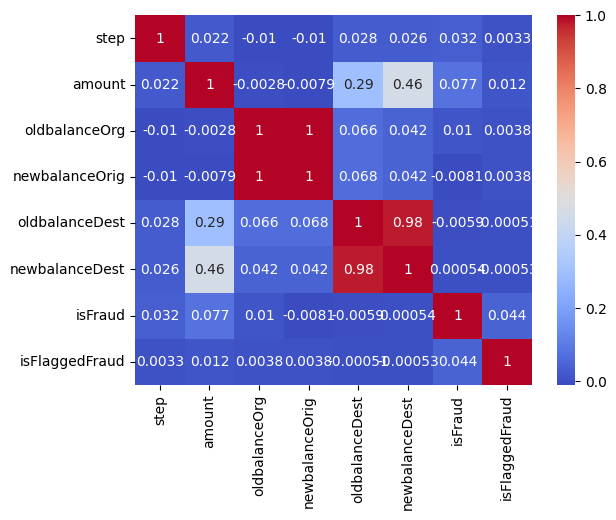

In [ ]:
#Test for Multicollinearity
col = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud']

corr_matrix = df[col].corr()

sns.heatmap(data=corr_matrix, annot=True,cmap='coolwarm')



* Old/New Balance data correlate with each other too much, which indicates multicollinearity. We will remove the old balance data

In [ ]:
#Visualize the relationship between Step(time) and Amount in terms of Fraud labels

plt.figure(figsize=(10,6))

sns.scatterplot(data=df, x='amount', y='step',hue='isFraud', alpha=0.5)

plt.xlabel('Step')
plt.ylabel('Amount')
plt.title('Scatter Plot of Step vs. Amount')

plt.grid(True)
plt.tight_layout()
plt.legend(title='Is Fraud')
plt.show()

* Above we can see that all of the fraudulent labels fall within a step size of 0 and 1 approximately 1 hour of a transaction occuring

Text(0.5, 1.0, 'Distribution of Fraud Labels')

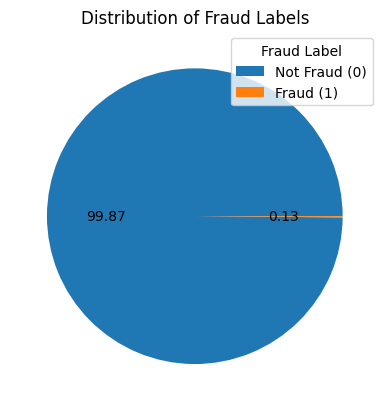

In [ ]:
#What is the ratio for true and false labels? (Fraud and not fraud)

plt.pie(df['isFraud'].value_counts(), autopct='%.2f')
plt.legend(title='Fraud Label', labels=['Not Fraud (0)', 'Fraud (1)'], loc='upper right')
plt.title('Distribution of Fraud Labels')

* The ratio for fraud and not fraud entries is highly disproportionate. The amount of true fraudulent entries is extrememly low.

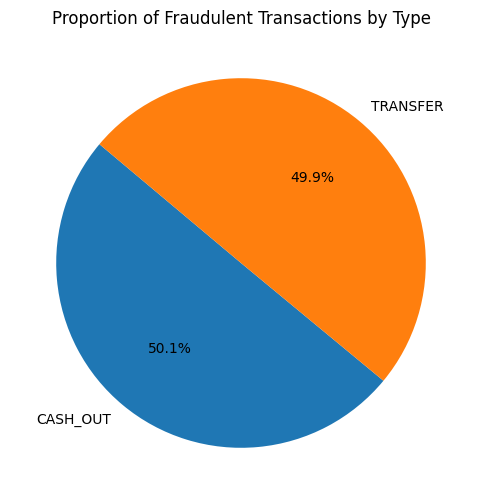

In [ ]:
#Show what percentage of transaction types contain fraudulent occurences

fraud_proportion = df[df['isFraud'] == 1]['type'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(fraud_proportion, labels=fraud_proportion.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Fraudulent Transactions by Type')
plt.show()

* Fraudulent transactions occure only in CASH OUT and TRANSFER payment categories

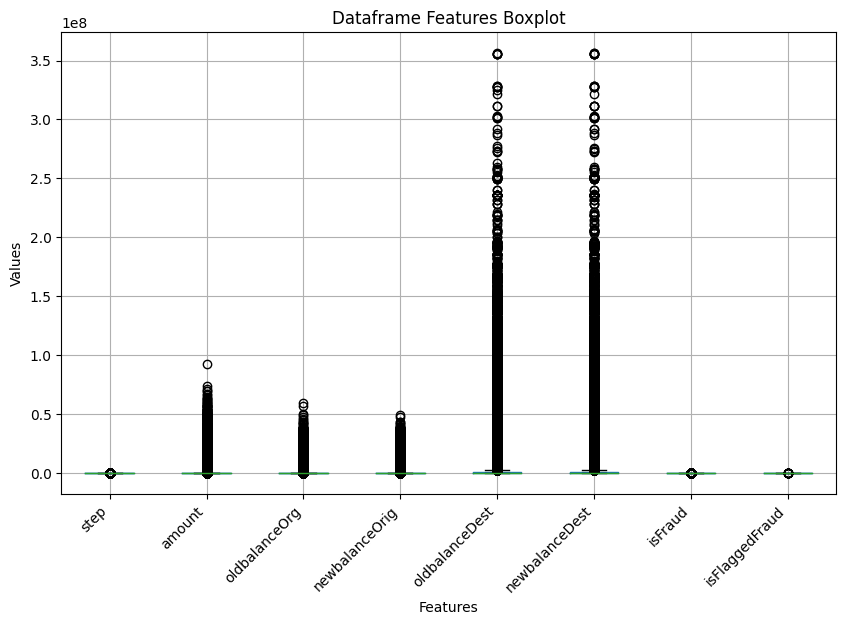

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
df.boxplot(ax=ax)
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Dataframe Features Boxplot')
plt.xticks(rotation=45, ha='right')
plt.show()

* There appears to be some considerable outliers in amount, oldbalanceDest, newbalanceDest. These could be indicators of fraud but may also be just errors in data entry. We may need to keep this in mind later

In [ ]:
#Count unique values in nameOrig and nameDest

nameOrig_tally = df['nameOrig'].value_counts()
nameDest_tally = df['nameDest'].value_counts()

print("Value counts in nameOrig")
print(nameOrig_tally)
print()

print("Value counts in nameDes")
print(nameDest_tally)

Value counts in nameOrig
nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: count, Length: 6353307, dtype: int64

Value counts in nameDes
nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: count, Length: 2722362, dtype: int64


* We already hypothesized that the names of the origin/dest would not be helpful in predicting fraud. The large number of unique names in the dataset also confirms that these names may not help us in classifying whether an observation is fraudulent or not

#3. Data Handling and Feature Engineering

In [ ]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


* We can make a new column called 'percent_change' which can better capture how much an account's balance changes

* We know that we want to remove oldbalance data since it has a high correlation with newbalance data.

* We need to convert our categorical data into numerical data using one hot encoding

* We need to remove redundant data that won't help in classifying fraud, such as the names of the origin of the transaction and destination. We also want to remove the 'flaggedFraud' feature since we are the ones who are classifying fraud or not.

* We need to upscale our fraudulent transaction data so we can remove the imbalance and our models have enough data in both fraud/non fraud to train on

Percent Change

In [ ]:
df["per_change"] = ((df["newbalanceOrig"] - df["oldbalanceOrg"])/(df["oldbalanceOrg"]))
df["per_change"] = pd.Series(np.where(df["oldbalanceOrg"] == 0.0,0,df["per_change"]))

df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,per_change
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,-0.057834
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,-0.087735
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,-1.000000
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,-1.000000
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,-0.280795


Check for multicollinearity again

Since we are adding features to our dataset, it is important to check for multicolinearity again

<Axes: >

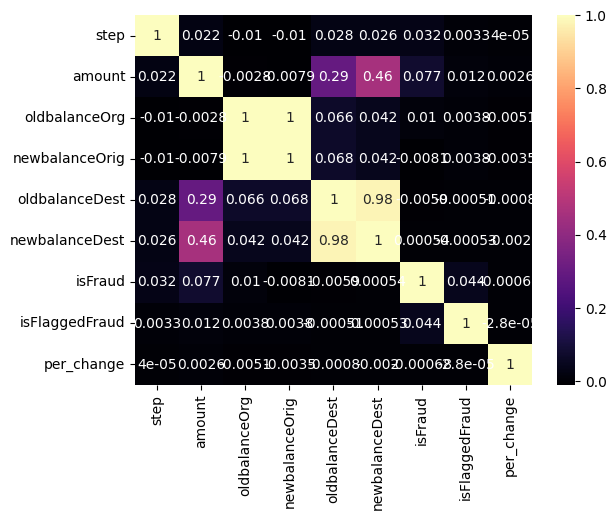

In [ ]:
#Test for Multicollinearity
col = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud','per_change']

corr_matrix = df[col].corr()

sns.heatmap(data=corr_matrix, annot=True,cmap='magma')


Since our transactions types only take one value at a time, we can apply one hot encoding on the categorial data (Transaction Types).

In [ ]:
df = pd.get_dummies(df, columns=['type'], drop_first=False)
df.head(5)

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,per_change,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,-0.057834,False,False,False,True,False
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,-0.087735,False,False,False,True,False
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,-1.000000,False,False,False,False,True
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,-1.000000,False,True,False,False,False
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,-0.280795,False,False,False,True,False


One Hot Encoding can result in something called the "Dummy Variable Trap", where variables are highly correlated to one another (multicollinearity as we've seen before). Since we are essentially adding new features to our dataset, we need to ensure that they will not negatively affect the interpretability of our classification model.

Instead of relying on a heat map to look for multicollinearity, we can use Variance Infalation Factor to calculate how correlated independent variables are. VIF is also used in multilinear regression (testing the affects of multiple variables on a specific outcome), but it also appears as an issue in logistics regression (binary classification)

Variance Inflation Factor: https://www.investopedia.com/terms/v/variance-inflation-factor.asp

Code from: https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/



In [ ]:
#Calculate VIF
def calculate_vif(data):
    vif_df = pd.DataFrame(columns=['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data.drop(columns=[x_var_names[i]])
        r_squared = sm.OLS(y, x).fit().rsquared
        vif = round(1 / (1 - r_squared), 2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by='Vif', ascending=False)


test_df = df.select_dtypes(include=['bool', 'int64', 'float64']).astype(int)


vif_df = calculate_vif(test_df)
print(vif_df)


               Var     Vif
3   newbalanceOrig  688.80
2    oldbalanceOrg  669.24
5   newbalanceDest   79.00
4   oldbalanceDest   68.60
1           amount    4.08
9     type_CASH_IN    2.82
10   type_CASH_OUT    2.10
12    type_PAYMENT    2.00
13   type_TRANSFER    1.48
6          isFraud    1.23
11      type_DEBIT    1.02
0             step    1.00
8       per_change    1.00
7   isFlaggedFraud    1.00


Remove redundant data

In [ ]:
df = df.drop(columns=['isFlaggedFraud','oldbalanceOrg','oldbalanceDest','nameOrig','nameDest','type_CASH_IN','type_DEBIT','type_PAYMENT','newbalanceDest'])
df.head(5)

,step,amount,newbalanceOrig,isFraud,per_change,type_CASH_OUT,type_TRANSFER
0,1,9839.64,160296.36,0,-0.057834,False,False
1,1,1864.28,19384.72,0,-0.087735,False,False
2,1,181.00,0.00,1,-1.000000,False,True
3,1,181.00,0.00,1,-1.000000,True,False
4,1,11668.14,29885.86,0,-0.280795,False,False


In [ ]:
test_df = df.drop(columns=['isFraud'])

In [ ]:
pip install statsmodels

In [ ]:
test_df = test_df.select_dtypes(include=['bool', 'int64', 'float64']).astype(int)


#Re-run the VIF calculation
vif_df = calculate_vif(test_df)
print(vif_df)


              Var   Vif
0            step  1.61
4   type_CASH_OUT  1.43
5   type_TRANSFER  1.30
1          amount  1.27
3      per_change  1.00
2  newbalanceOrig  0.07


We can see that our independent variables have VIF scores within the 1 - 5 range, which implies that our features have some correlation to each other, but not too much.

Check for mulicollineary one more time

In [ ]:
#Test for Multicollinearity
col = ['step','amount','newbalanceOrig','per_change']

corr_matrix = df[col].corr()

sns.heatmap(data=corr_matrix, annot=True,cmap='magma')

KeyError: "['newbalanceDest'] not in index"

* NewbalanceDest and Amount show a higher value of corellation, but we will disregard this since it is below 50%

Balance the data

In [ ]:
from imblearn.over_sampling import SMOTE

df = df.sample(n=600000, random_state=42)

X = df.drop('isFraud', axis=1)
y = df['isFraud']

'''
smote = SMOTE(sampling_strategy='auto', random_state=42)
X,y = smote.fit_resample(X,y)
'''

"\nsmote = SMOTE(sampling_strategy='auto', random_state=42)\nX,y = smote.fit_resample(X,y)\n"

In [ ]:
y.value_counts()

,count
isFraud,
0,599240
1,760


* As we can see, the data is now balanced. We have an equal amount of fraudulent and non fraudulent transactions

Remove Outliers

In [ ]:
numeric_columns = df.select_dtypes(include=['int64','float64'])


Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1


def detect_outliers(column):
    lower_bound = Q1[column] - 1.5 * IQR[column]
    upper_bound = Q3[column] + 1.5 * IQR[column]
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    if outliers.empty:
        return None, 0.0
    else:
        percentage = (len(outliers) / len(df)) * 100
        return column, percentage

columns_with_outliers = [detect_outliers(column) for column in numeric_columns.columns]
columns_with_outliers = [(column, percentage) for column, percentage in columns_with_outliers if column is not None]

for column, percentage in columns_with_outliers:
    print(f"Column: {column}, Percentage of outliers: {percentage:.2f}%")

Column: step, Percentage of outliers: 1.63%
Column: amount, Percentage of outliers: 5.33%
Column: newbalanceOrig, Percentage of outliers: 16.55%
Column: isFraud, Percentage of outliers: 0.13%
Column: per_change, Percentage of outliers: 6.95%


In [ ]:

def remove_outlier(col):
    sorted(col)
    Q1,Q3=col.quantile([0.25,0.75])
    IQR=Q3-Q1
    lower_range=Q1-1.5*IQR
    upper_range=Q3+1.5*IQR
    return lower_range,upper_range

In [ ]:

columns_to_remove_outliers = ['step', 'amount', 'newbalanceOrig', 'per_change']

for col in columns_to_remove_outliers:
    low_threshold, high_threshold = remove_outlier(df[col])
    df[col] = np.where(df[col] > high_threshold, high_threshold, df[col])
    df[col] = np.where(df[col] < low_threshold, low_threshold, df[col])

Split the data and then normalize the X data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#turns 25% of the training data into validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
X_train.head(80)

,step,amount,newbalanceOrig,per_change,type_CASH_OUT,type_TRANSFER
2843551,226,151087.14,18265617.01,0.008341,False,False
4780325,335,52868.16,0.00,0.000000,True,False
4513064,325,1805.88,4879.12,-0.270139,False,False
3085407,235,10057.98,13181.02,-0.432806,True,False
3309220,252,202668.53,0.00,-1.000000,True,False
...,...,...,...,...,...,...
4774212,335,416.77,298523.24,-0.001394,False,False
1281574,135,302075.51,0.00,-1.000000,False,True
1886847,164,105492.10,0.00,-1.000000,True,False
4080527,301,154348.53,0.00,0.000000,True,False


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train,y_train = smote.fit_resample(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Fraud Labels')

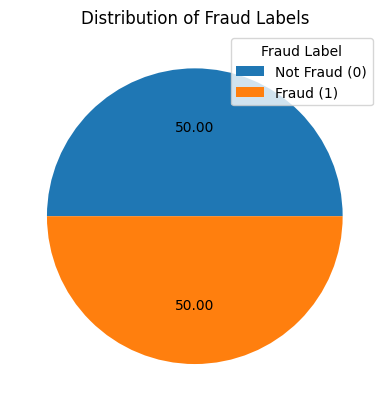

In [ ]:
plt.pie(y_train.value_counts(), autopct='%.2f')
plt.legend(title='Fraud Label', labels=['Not Fraud (0)', 'Fraud (1)'], loc='upper right')
plt.title('Distribution of Fraud Labels')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#Normalizes x data

scaler  = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

print(X_train)

[[3.03643725e-01 2.17901281e-03 5.05275140e-01 1.83698452e-06
  0.00000000e+00 0.00000000e+00]
 [4.50742240e-01 7.62474278e-04 0.00000000e+00 1.82178959e-06
  1.00000000e+00 0.00000000e+00]
 [4.37246964e-01 2.60413887e-05 1.34969327e-04 1.32965296e-06
  0.00000000e+00 0.00000000e+00]
 ...
 [7.23346829e-01 7.54822803e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [4.85829960e-01 5.89626291e-04 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [2.56410256e-01 2.10364326e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


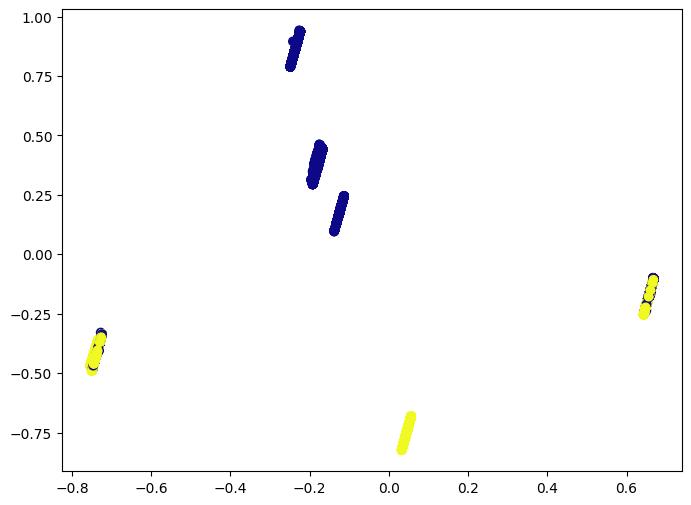

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0],X_train[:,1],c=y_train,cmap='plasma')


#4. Logistic Regression

In [ ]:
lgr = LogisticRegression(max_iter=500)
lgr.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [ ]:
y_pred = lgr.predict(X_test)

In [ ]:
LGR_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", LGR_accuracy)

print(classification_report(y_test, y_pred))

Accuracy: 0.914175
              precision    recall  f1-score   support

           0       1.00      0.91      0.96    119861
           1       0.01      0.72      0.02       139

    accuracy                           0.91    120000
   macro avg       0.50      0.82      0.49    120000
weighted avg       1.00      0.91      0.95    120000



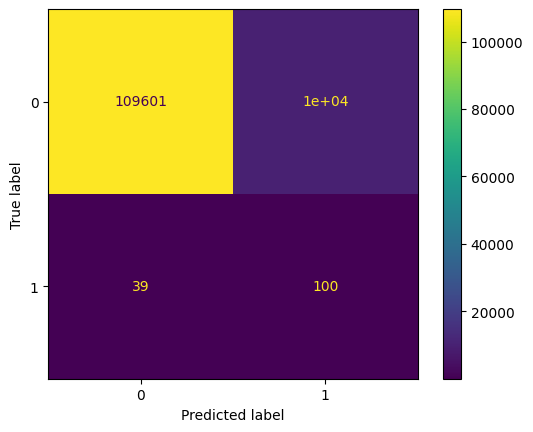

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics


confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

# Random Forest

In [ ]:

rf_model = RandomForestClassifier(random_state = 42)

rf_model.fit(X_train,y_train)


RandomForestClassifier(random_state=42)

In [ ]:

RF_predictions = rf_model.predict(X_test)

RF_accuracy = accuracy_score(y_test, RF_predictions)
print("Accuracy:", RF_accuracy)

print(classification_report(y_test, RF_predictions))

Accuracy: 0.9936544623189373
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    119749
           1       0.99      1.00      0.99    119947

    accuracy                           0.99    239696
   macro avg       0.99      0.99      0.99    239696
weighted avg       0.99      0.99      0.99    239696



# Neural Network

In [ ]:
# Parameters
#//////////////////////
learning_rate = 0.01
epochs = 100
batch_size = 128
#/////////////////////

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU

model = Sequential([
    Dense(units=10, input_shape=(X_train.shape[-1],)),
    LeakyReLU(alpha=0.01),

    Dense(units=150),
    LeakyReLU(alpha=0.01),

    Dropout(0.1),

    Dense(units=200),
    LeakyReLU(alpha=0.01),

    Dropout(0.1),

    Dense(units=150),
    LeakyReLU(alpha=0.01),

    Dense(units=1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 10)                  │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 150)                 │           1,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 300)                 │          45,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 150)                 │          45,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,321 (360.63 KB)

 Trainable params: 92,321 (360.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow import keras



model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=['accuracy', 'Recall'],
)

In [ ]:


#Define the learning rate reduction callback
lr_reduction = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    min_delta = 0.0002,
    patience  = 20,
    restore_best_weights=True,
)

model_checkpoint = ModelCheckpoint(
    filepath='/content/drive/MyDrive/CTP_FRAUD_STORAGE/models/fraud_wt_smote_train.weights.h5',
    save_weights_only=True,
    monitor='val_recall',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(X_val, y_val),
          verbose=1,
          callbacks=[lr_reduction, early_stopping, model_checkpoint])

Epoch 1/100
5618/5618 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - Recall: 0.8978 - accuracy: 0.8941 - loss: 0.2293 - val_Recall: 0.8631 - val_accuracy: 0.9034 - val_loss: 0.1926 - learning_rate: 0.0010
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_recall available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


5618/5618 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - Recall: 0.9178 - accuracy: 0.9122 - loss: 0.1945 - val_Recall: 0.8452 - val_accuracy: 0.9107 - val_loss: 0.1757 - learning_rate: 0.0010
Epoch 3/100
5618/5618 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - Recall: 0.9171 - accuracy: 0.9139 - loss: 0.1881 - val_Recall: 0.8393 - val_accuracy: 0.9193 - val_loss: 0.1753 - learning_rate: 0.0010
Epoch 4/100
5618/5618 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - Recall: 0.9152 - accuracy: 0.9148 - loss: 0.1872 - val_Recall: 0.8571 - val_accuracy: 0.9059 - val_loss: 0.2099 - learning_rate: 0.0010
Epoch 5/100
5618/5618 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - Recall: 0.9154 - accuracy: 0.9155 - loss: 0.1848 - val_Recall: 0.8393 - val_accuracy: 0.9137 - val_loss: 0.2025 - learning_rate: 0.0010
Epoch 6/100
5618/5618 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - Recall: 0.9150 - accuracy: 0.9167 - loss: 0.1829 - val_Recall: 0.8333 - val_accuracy: 0.9199 - val_loss: 0.1753 - learning_rate: 0.0010
Epoch 7/100
5618/5618 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
final = model.predict(X_test)
y_pred = (final > 0.5).astype("int32")

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [ ]:

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9316
Precision: 0.013388011096369558
Recall: 0.7985611510791367
F1 Score: 0.026334519572953737


#Github

In [ ]:
!git clone https://github.com/evanperez444/Credit-Card-Fraud-Detection-with-Neural-Networks.git

Cloning into 'Credit-Card-Fraud-Detection-with-Neural-Networks'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 490.83 KiB | 2.76 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:

!git add .

!git commit -m "Updating"

!git push

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
